# Transformer Training and Evaluation

This notebook is used to train and evaluate the Transformer model. The model is set up and trained on the data that are procuced by executing the ```data_preparation.ipynb``` notebook. The evaluation is done by calculating the mean absolute percentage error (MAPE) and variance ratio.

In [2]:

import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import layers
import time
import timeit
import pickle as pkl


import import_ipynb
import helper_functions

importing Jupyter notebook from helper_functions.ipynb


## Data Loading

The data are imported from the ```datasets/data.csv``` file, which is produced by the ```data_preparation.ipynb``` notebook. 

In [3]:
# load data from datasets/data.pkl
# if data is not available, remind user to run data_preprocessing.ipynb
if any(file not in os.listdir('datasets') for file in ['df.pkl', 'train.pkl', 'test.pkl', 'X_train.pkl', 'y_train.pkl', 'X_test.pkl', 'y_test.pkl']):
    print('Data not found! Please run data_preprocessing.ipynb to generate the necessary pkl files.')    
else:
    df = pkl.load(open('datasets/df.pkl', 'rb'))
    train = pkl.load(open('datasets/train.pkl', 'rb'))
    test = pkl.load(open('datasets/test.pkl', 'rb'))
    X_train = pkl.load(open('datasets/X_train.pkl', 'rb'))
    y_train = pkl.load(open('datasets/y_train.pkl', 'rb'))
    X_test = pkl.load(open('datasets/X_test.pkl', 'rb'))
    y_test = pkl.load(open('datasets/y_test.pkl', 'rb'))
    data = { 'df':df, 'train': train, 'test': test, 'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test }


## Encoder Setup

The `transformer_encoder` function constructs a single transformer block, which is a fundamental component of a transformer model. This block is designed to handle complex relationships in sequence data, making it suitable for tasks the task of stock price forecasting.

### Function Structure and Capabilities:

- **Normalization and Attention**:
  - **Layer Normalization**: Applies normalization on the input layer, stabilizing the neural network which helps in faster training and reducing the chances of overfitting.
  - **Multi-Head Attention**: Allows the model to jointly attend to information from different representation subspaces at different positions, with parameters like head size and number of heads.
  - **Dropout**: Added after the attention mechanism to prevent overfitting during training.

- **Residual Connection**: Integrates the input with the output of the attention mechanism, aiding in mitigating the vanishing gradient problem in deep networks.

- **Feed-Forward Network**:
  - **Convolution Layers**: Two convolution layers with ReLU activation in between add non-linearity to the model, enhancing its ability to capture complex patterns in data.
  - **Output**: Combines the result from the convolutional layers with the residual connection output, maintaining the flow of gradients and preventing information loss.





In [4]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=epsilon)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res




## Transformer Model Setup

The `build_transformer` function orchestrates multiple `transformer_encoder` blocks to assemble the complete transformer model. This model leverages the transformer architecture's ability to handle sequential data, making it highly effective for forecasting tasks.

### Model Architecture and Training Process:

- **Input Specification**: Begins with defining the input shape that matches the expected sequence length and features in the data.

- **Stacking Encoder Blocks**: Repeatedly applies the `transformer_encoder` to the inputs, stacking specified numbers of these blocks to enhance the model’s depth and capacity for handling complex data patterns.

- **Pooling and Dense Layers**:
  - **Global Average Pooling**: Reduces the dimensionality of the output from the transformer blocks, summarizing the features learned.
  - **Dense Layers with Dropout**: A series of dense layers with dropout improves the robustness of the model, culminating in an output layer that predicts the desired number of future steps.


In [5]:

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = 5, 1, 5
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)

## Model Training

The `fit_transformer` function is responsible for the final stages of preparing and training the transformer model, optimizing its parameters to best fit the training data.

### Compilation and Training:

- **Compilation**: The transformer model is compiled with mean squared error (MSE) as the loss function and the Adam optimizer for efficient learning. It also tracks mean absolute error (MAE) and mean absolute percentage error (MAPE) to evaluate performance during training.

- **Training**:
  - **Callbacks**: Includes an EarlyStopping callback to terminate training if the loss does not improve for 10 consecutive epochs, which helps in preventing overfitting and ensures the best model is retained.
  - **Training Execution**: The model is trained on the provided datasets with a fixed batch size and number of epochs, using verbose output to monitor progress in real-time. The function also records the training time, providing insights into the computational efficiency of the training process.



In [8]:
def fit_transformer(transformer: tf.keras.Model):
  """
  Compiles and fits our transformer.
  """
  transformer.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape'])

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
  start = time.time()
  hist = transformer.fit(data["X_train"], data["y_train"], batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
  print(time.time() - start)
  return hist


In [9]:
model = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
history = fit_transformer(model)

Epoch 1/25
273/273 [==============================] - 14s 16ms/step - loss: 3.3882 - mae: 0.5198 - mape: 56.3166
Epoch 2/25
273/273 [==============================] - 5s 18ms/step - loss: 0.3187 - mae: 0.2245 - mape: 18.0280
Epoch 3/25
273/273 [==============================] - 5s 19ms/step - loss: 0.2439 - mae: 0.2025 - mape: 17.9133
Epoch 4/25
273/273 [==============================] - 5s 19ms/step - loss: 0.2119 - mae: 0.1886 - mape: 17.0073
Epoch 5/25
273/273 [==============================] - 5s 17ms/step - loss: 0.1709 - mae: 0.1710 - mape: 14.6098
Epoch 6/25
273/273 [==============================] - 4s 16ms/step - loss: 0.1897 - mae: 0.1778 - mape: 14.6239
Epoch 7/25
273/273 [==============================] - 5s 17ms/step - loss: 0.1692 - mae: 0.1664 - mape: 12.7789
Epoch 8/25
273/273 [==============================] - 5s 18ms/step - loss: 0.1623 - mae: 0.1615 - mape: 11.1845
Epoch 9/25
273/273 [==============================] - 5s 17ms/step - loss: 0.1482 - mae: 0.1550 - mape:

## Model Evaluation

In [10]:
transformer_preds = helper_functions.PredictAndForecast(model, data["train"], data["test"])
transformer_evals = helper_functions.Evaluate(data["test"], transformer_preds.predictions)

# transformer_evals.mape, transformer_evals.var_ratio
print("Transformer MAPE: ", transformer_evals.mape)
print("Transformer Variance Ratio: ", transformer_evals.var_ratio)

Transformer MAPE:  0.023392971932615764
Transformer Variance Ratio:  0.012118420825092291


In [11]:
# Visualize predictions and actual values
def plot_results(test, preds, df,  title_suffix=None, xlabel='AAPL stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """
    fig, ax = plt.subplots(figsize=(20,6))
    # x = df.Close[-498:].index
    plot_test = test[1:]
    plot_preds = preds[1:]
    # plot_test = np.array(plot_test)

    x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index.to_numpy()
    plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    ax.plot(x, plot_test, label='actual')
    ax.plot(x, plot_preds, label='preds')
    if title_suffix==None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()

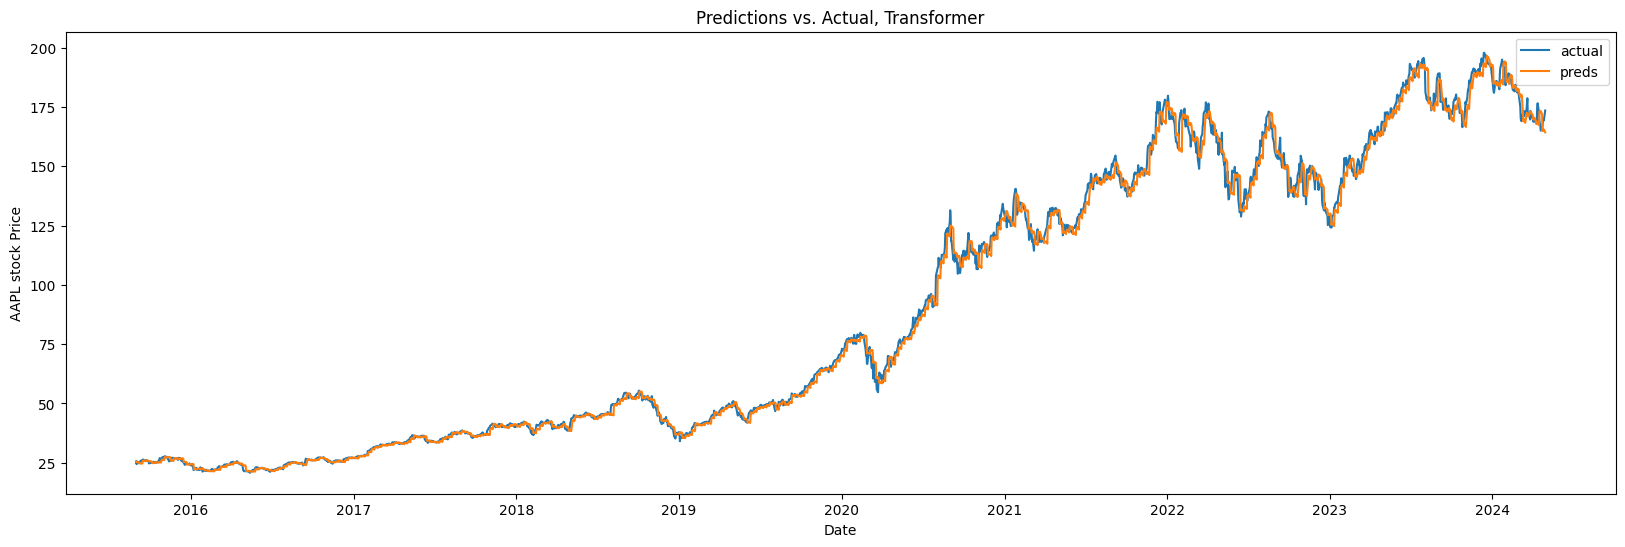

In [12]:
plot_results(data["test"], transformer_preds.predictions, data["df"], title_suffix='Transformer')